# Task 1: Train a CNN to Predict a Clear Road Ahead

In [5]:
import numpy as np
from minirace import Minirace
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

First, run the given "sprites.py" file to create the datasets. The code below is the entire "sprites.py" script.

In [2]:
therace = Minirace(level=1)

# create big enough dataset
rows = therace.xymax * therace.xymax * 5
columns = therace.xymax * therace.xymax + 1

alldata = np.zeros((rows, columns), dtype=int)

for i in range(rows):
    therace.reset()
    for j in range(2):
        x, z, _ = therace.s1
        if abs(z[2] - x) <= 1.0:
            therace.transition()
    
    x, z, _ = therace.s1
    alldata[i,:-1] = therace.to_pix(x, z).flatten()
    
    if (abs(z[2] - x) <= 1.0):
        alldata[i,-1] = 1.0
    else:
        alldata[i,-1] = 0.0
        
# save all pictures and all labels in random order, two separate files            
np.random.seed(10)
neworder = np.random.choice(rows, size=rows, replace=False)
alldata = alldata[neworder,:]
np.savetxt('alldata.csv', alldata, delimiter=',', fmt='%d')

# number of training and test samples
ntrain = round(0.8 * rows)
ntest = rows - ntrain

trainingdata = alldata[0:ntrain,:]
testingdata = alldata[ntrain:,:]

np.savetxt('trainingpix.csv', trainingdata, delimiter=',', fmt='%d')
np.savetxt('testingpix.csv', testingdata, delimiter=',', fmt='%d')

# Loss Function Choice

First, what is a good loss function for this problem? In this problem, we have two possible outcomes—either the car can safely continue straight (label 1) or it cannot (label 0). This makes it a classification task, so the appropriate choice would be a cross-entropy loss function. In general, cross-entropy measures the difference between the true distribution of labels and the probability distribution predicted by the model, penalizing the model more when it assigns low probability to the correct outcome.

For this task, this version of cross-entropy specifically handles two-class problems by comparing the predicted probability of safety with the actual label, so we can use binary cross-entropy loss. Minimizing this loss guides the CNN to adjust its weights so that its predictions align closely with whether the road ahead is clear, directly supporting the survival objective of the racing game.

# Training the CNN on the Training Dataset

Now, let's create a CNN that predicts whether the car can safely remain on the current position (i.e., drive straight) without crashing into non-drivable terrain.

In [ ]:
# Load and access dataset
train_df = pd.read_csv("trainingpix.csv", header=None)


# Split into features (X) and labels (y)
# X: all columns except last -> pixel values
# y: last column -> 0/1 label for "safe to go straight"
X_train = train_df.iloc[:, :-1].values.astype(np.float32)
y_train = train_df.iloc[:, -1].values.astype(np.float32)

# Normalize pixel values from [0,1,2] to [0.0,1.0]
X_train /= 2.0

# Reshape for CNN input (N, C, H, W)
# N = number of samples
# C = number of channels (1 for grayscale)
# H = height (16)
# W = width (16)
X_train = X_train.reshape(-1, 1, 16, 16)

# Convert to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In the following CNN, the first convolutional layer detects simple, local patterns in the 16×16 input, such as edges of the track, boundaries between drivable and non-drivable terrain, or the location of the car itself. The second convolutional layer builds on these low-level features by combining them to recognize slightly larger structures, such as the shape of the road ahead, gaps in the track, or small clusters of non-drivable terrain that the car must avoid.

ReLU activations are applied after each convolution to introduce non-linearity, allowing the network to model more complex relationships than a linear model could. Max pooling layers follow the convolutions to reduce the spatial dimensions of the feature maps, which decreases the number of parameters, helps prevent overfitting, and prevents small shifts in the car’s position from drastically affect the output.

Dropout is included before the fully connected layers to further reduce overfitting by randomly ignoring some neuron activations during training. Finally, the fully connected layers combine the extracted features to produce a single logit for binary classification, indicating whether the car can safely drive straight in the next step. This architecture balances the need for spatial feature extraction with the small input size and limited complexity of the dataset.

In [ ]:
class MiniRaceCNN(nn.Module):
    def __init__(self):
        super(MiniRaceCNN, self).__init__()

        # First convolutional layer
        # Input: 1 channel (grayscale), Output: 16 feature maps
        # Kernel size: 3x3, Padding: 1 (keeps spatial size 16x16)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)

        # Max pooling layer
        # Reduces height and width by a factor of 2
        # After pooling: 16x16 -> 8x8
        self.pool = nn.MaxPool2d(2, 2)

        # Second convolutional layer
        # Input: 16 feature maps, Output: 32 feature maps
        # Kernel size: 3x3, Padding: 1 (keeps size after conv: 8x8)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        # Fully connected layer 1
        # Input: flatten 32 feature maps of 4x4 after pooling -> 32*4*4=512
        # Output: 64 features
        self.fc1 = nn.Linear(32 * 4 * 4, 64)

        # Fully connected layer 2
        # Input: 64 features, Output: 1 logit (for binary classification)
        self.fc2 = nn.Linear(64, 1)

        # Dropout layer
        # Randomly zero 20% of elements during training to prevent overfitting
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # Apply first convolution -> ReLU activation -> pooling
        # Input: (batch_size, 1, 16, 16)
        # After conv1+ReLU: (batch_size, 16, 16, 16)
        # After pool: (batch_size, 16, 8, 8)
        x = self.pool(torch.relu(self.conv1(x)))

        # Apply second convolution -> ReLU -> pooling
        # After conv2+ReLU: (batch_size, 32, 8, 8)
        # After pool: (batch_size, 32, 4, 4)
        x = self.pool(torch.relu(self.conv2(x)))

        # Flatten tensor for fully connected layers
        # (batch_size, 32, 4, 4) -> (batch_size, 32*4*4 = 512)
        x = x.view(-1, 32 * 4 * 4)

        # Apply dropout
        x = self.dropout(x)

        # Fully connected layer + ReLU
        x = torch.relu(self.fc1(x))  # (batch_size, 64)

        # Output layer (single logit for BCEWithLogitsLoss)
        x = self.fc2(x)              # (batch_size, 1)

        # Remove extra dimension to match target shape (batch_size,)
        return x.squeeze(1)
    

Epoch [1/50]  Loss: 0.6762  Accuracy: 57.81%
Epoch [2/50]  Loss: 0.6491  Accuracy: 66.99%
Epoch [3/50]  Loss: 0.5623  Accuracy: 73.34%
Epoch [4/50]  Loss: 0.4385  Accuracy: 81.05%
Epoch [5/50]  Loss: 0.2982  Accuracy: 91.11%
Epoch [6/50]  Loss: 0.1614  Accuracy: 96.39%
Epoch [7/50]  Loss: 0.0957  Accuracy: 98.14%
Epoch [8/50]  Loss: 0.0594  Accuracy: 99.02%
Epoch [9/50]  Loss: 0.0408  Accuracy: 99.12%
Epoch [10/50]  Loss: 0.0252  Accuracy: 99.71%
Epoch [11/50]  Loss: 0.0204  Accuracy: 99.80%
Epoch [12/50]  Loss: 0.0141  Accuracy: 99.90%
Epoch [13/50]  Loss: 0.0122  Accuracy: 99.90%
Epoch [14/50]  Loss: 0.0102  Accuracy: 99.80%
Epoch [15/50]  Loss: 0.0057  Accuracy: 100.00%
Epoch [16/50]  Loss: 0.0094  Accuracy: 99.80%
Epoch [17/50]  Loss: 0.0037  Accuracy: 100.00%
Epoch [18/50]  Loss: 0.0027  Accuracy: 100.00%
Epoch [19/50]  Loss: 0.0059  Accuracy: 100.00%
Epoch [20/50]  Loss: 0.0032  Accuracy: 100.00%
Epoch [21/50]  Loss: 0.0018  Accuracy: 100.00%
Epoch [22/50]  Loss: 0.0017  Accuracy

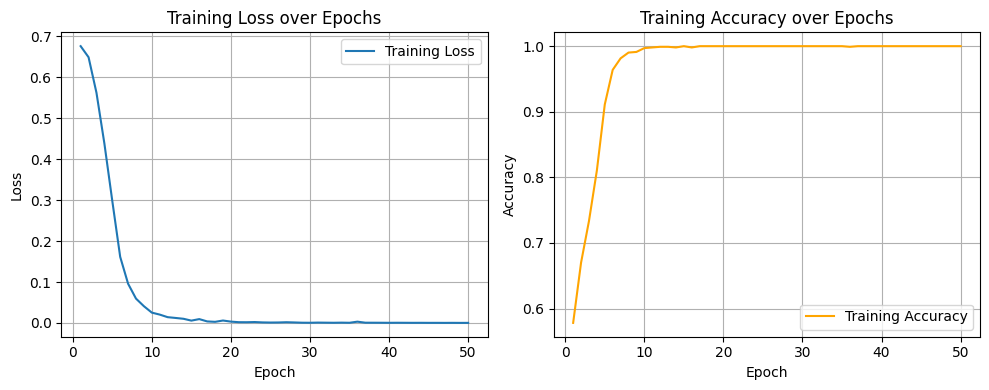

In [ ]:
# Initialize model, loss, and optimizer
model = MiniRaceCNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
epochs = 50

# Store loss and accuracy per epoch
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute batch accuracy
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    # Compute average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{epochs}]  Loss: {epoch_loss:.4f}  Accuracy: {epoch_acc*100:.2f}%")

# Plot training curves 
plt.figure(figsize=(10, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Testing the CNN on the Test Dataset

In [7]:
# Load and preprocess the dataset
test_df = pd.read_csv("testingpix.csv", header=None)

# Split into features and labels
X_test = test_df.iloc[:, :-1].values.astype(np.float32)
y_test = test_df.iloc[:, -1].values.astype(np.float32)

# Normalize pixel values
X_test /= 2.0

# Reshape for CNN: (N, C, H, W)
X_test = X_test.reshape(-1, 1, 16, 16)

# Convert to PyTorch tensors
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

In [8]:
# Evaluate the model
model.eval()  # set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # no gradient tracking
    outputs = model(X_test_tensor)           # forward pass
    predictions = (torch.sigmoid(outputs) > 0.5).float()  # threshold logits at 0.5
    correct = (predictions == y_test_tensor).sum().item()  # count correct predictions
    total = y_test_tensor.size(0)                            

accuracy = correct / total
print(f"Test Accuracy: {accuracy*100:.2f}%")

Test Accuracy: 100.00%
